In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import expm
from numpy.linalg import norm, matrix_power
from functools import reduce
from itertools import product
import time

## for higher order the coefficients are of order 10^24/10^28
B_sign = {3: (np.array([-1,0,1]),2),
          5: (np.array([1,-8,0,8,-1]),12),
          7: (np.array([-1,9,-45,0,45,-9,1]),60),
          9: (np.array([3,-32,168,-672,0,672,-168,32,-3]),840),
          11: (np.array([-2,25,-150,600,-2100,0,2100,-600,150,-25,2]),2520)}

def make_B(N, coefs, cbase):
    """ make matrix B s.t. L = -BB.T with correct zero boundary conditions.
    N - size of B.
    coefs - list of coefficients.
    cbase - divider.
    
    """
    B = np.zeros((N,N))
    l = len(coefs)//2
    diags = list(range(-l,l+1))
    for i,val in zip(diags,coefs):
        B += val*np.eye(N,k=i)

    ### Boundary connditions
    ## left side
    B[0,:] = np.zeros_like(B[0,:])
    B[:,0] = np.zeros_like(B[:,0])
    
    for i in range(l):
        coef_temp = coefs[-(i+1):]
        B[l-i,:len(coef_temp)] = B[l-i,:len(coef_temp)] - coef_temp
        # print(l-i, coef_temp)
    B[:,0] = B[:,0]*np.sqrt(2)

    ## right side
    B[-1,:] = np.zeros_like(B[-1,:])
    B[:,-1] = np.zeros_like(B[:,-1])
    for i in range(l):
        coef_temp = coefs[:(i+1)]
        B[-(l-i)-1,-len(coef_temp):] = B[-(l-i)-1,-len(coef_temp):] - coef_temp
        # print(-(l-i)-1, coef_temp)
    B[:,-1] = B[:,-1]*np.sqrt(2)
    
    # return B
    return B/cbase


In [6]:
l = 5
t = 1 
c_max = 1 
A = 1

num_points_B = [3,5,7,9,11]
NQ_list = [1,2,3,4,5,6,7,8]
acc_order_errors = []


for n_points in num_points_B:
    print('{} points'.format(n_points))
    coef_B,cb_B = B_sign[n_points]
    error_list = []
    for NQ in NQ_list:
        time_start = time.time()
        nq = NQ - 1
        if 2**(nq) > n_points:
            x_real = np.linspace(0,l,2**(nq))
            dx = x_real[1]-x_real[0]
            B = make_B(2**(nq),coef_B,cb_B)
            assert len(x_real) == B.shape[0] 
            H = np.block([[np.zeros_like(B), B],[B.T, np.zeros_like(B)]])
            
            """ Initial conditions (classic) """
            psi_init = A*np.sin(x_real*np.pi/l)
            psi_init_norm = norm(psi_init)
            psi_init /= psi_init_norm # normalization init state
            dpsi_dt_init = np.zeros_like(x_real)
            psi_final = (A/psi_init_norm)*np.sin(x_real*np.pi/l)*np.cos(c_max*t*np.pi/l) # exact solution
#             psi_final /= norm(psi_final)

            """ Initial conditions (Schrodinger) """
            psi_0_sch = np.concatenate((psi_init, dpsi_dt_init))
#             psi_0_sch /= norm(psi_0_sch) # normalization of init schrod (not necessary)

            """ Numerical solution """
            exp_H = expm(-1j*H*c_max*t/dx)
            psi_sch_final = exp_H@psi_0_sch # numerical solution

            """ Error """
            psi_sch_final = psi_sch_final[:len(psi_sch_final)//2].real
            error = norm(psi_sch_final - psi_final)

            time_spend = time.time() - time_start
            print('\t{} qubits || error: {:.2E} || time: {:.3f} s'.format(NQ,error,time_spend))
            error_list.append(error)
        
    acc_order_errors.append(error_list)


der_acc_order_list = np.array(num_points_B)-1
acc_order_errors_array = []
for i in acc_order_errors:
    if len(i) < len(NQ_list):
        i = [None]*(len(NQ_list)-len(i))+i
    acc_order_errors_array.append(i)
acc_order_errors_array = np.array(acc_order_errors_array)    

3 points
	3 qubits || error: 5.90E-02 || time: 0.001 s
	4 qubits || error: 1.21E-02 || time: 0.001 s
	5 qubits || error: 2.69E-03 || time: 0.000 s
	6 qubits || error: 6.31E-04 || time: 0.001 s
	7 qubits || error: 1.53E-04 || time: 0.005 s
	8 qubits || error: 3.77E-05 || time: 0.021 s
5 points
	4 qubits || error: 4.87E-04 || time: 0.000 s
	5 qubits || error: 2.36E-05 || time: 0.000 s
	6 qubits || error: 1.30E-06 || time: 0.001 s
	7 qubits || error: 7.61E-08 || time: 0.003 s
	8 qubits || error: 4.61E-09 || time: 0.015 s
7 points
	4 qubits || error: 2.07E-05 || time: 0.001 s
	5 qubits || error: 2.21E-07 || time: 0.001 s
	6 qubits || error: 2.85E-09 || time: 0.001 s
	7 qubits || error: 4.05E-11 || time: 0.004 s
	8 qubits || error: 6.05E-13 || time: 0.017 s
9 points
	5 qubits || error: 2.14E-09 || time: 0.001 s
	6 qubits || error: 6.50E-12 || time: 0.001 s
	7 qubits || error: 2.24E-14 || time: 0.003 s
	8 qubits || error: 4.76E-15 || time: 0.015 s
11 points
	5 qubits || error: 2.13E-11 || ti

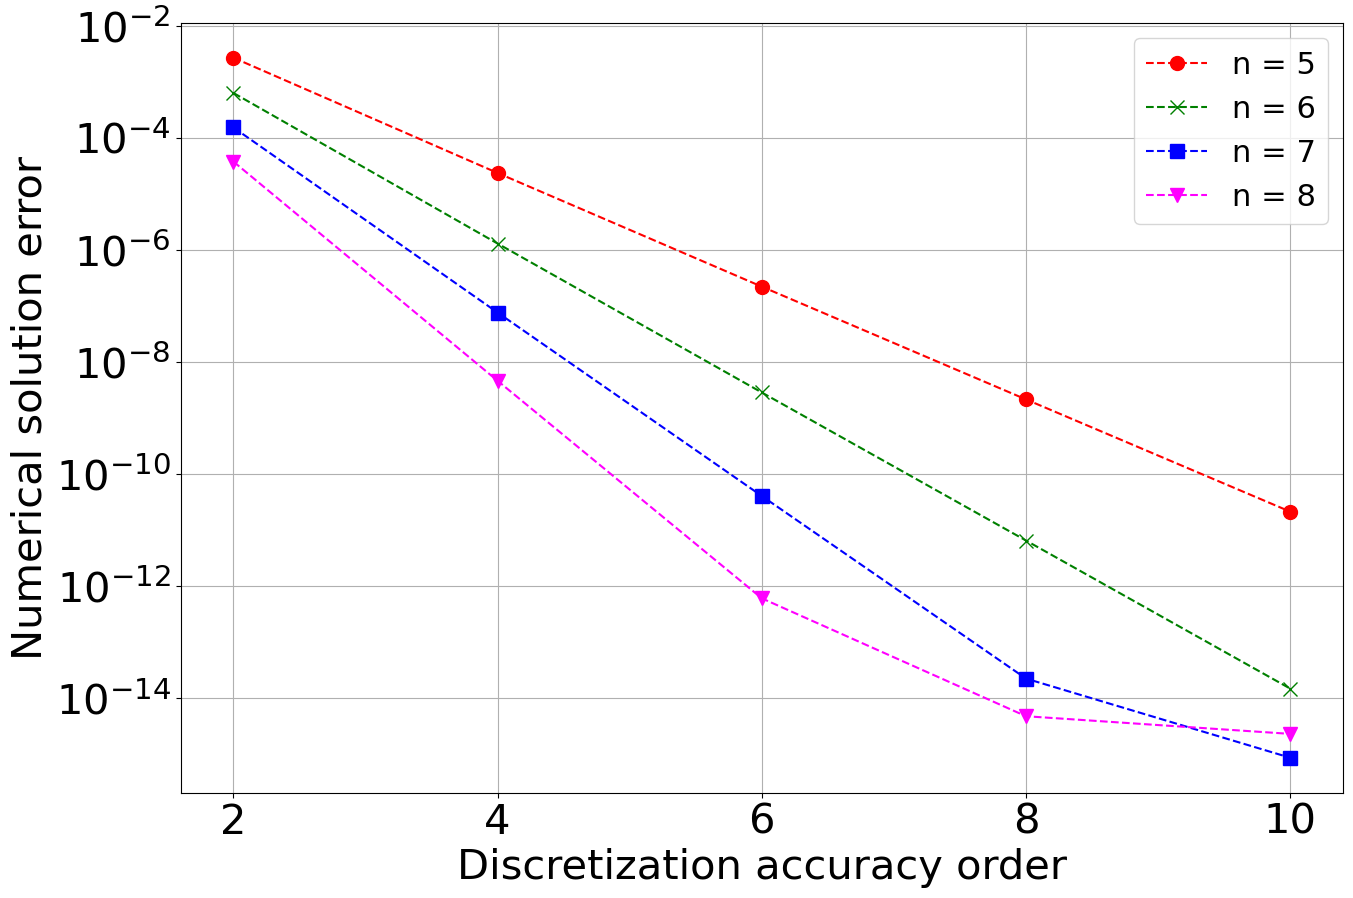

In [7]:
plt.figure(figsize = (15,10))

NQ_start = 4

colour_list = [None]*NQ_start + ['r','g','b','magenta']#,'black','orange']
marker_list = [None]*NQ_start + ['o','x','s','v']#,'black','orange']
assert len(colour_list) == len(NQ_list)


for acc_order_errors, NQ, c, m in zip(acc_order_errors_array.T, NQ_list, colour_list, marker_list):
#     assert (trotter_error_list < set_trotter_error).all()
    if NQ > NQ_start:
        plt.plot(der_acc_order_list, acc_order_errors, marker=m, c=c, markersize = 10,
                 linestyle='dashed',label='n = {}'.format(NQ))

plt.yscale('log')
# plt.xscale('log')
plt.grid(alpha = 1)
plt.legend(fontsize = 22)
# plt.title('Trotter error: $10^{%d}$; Trotter formula order: %d'%(int(np.log10(set_trotter_error)),p), fontsize = 30)
plt.xlabel('Discretization accuracy order', fontsize = 30 )
plt.ylabel('Numerical solution error', fontsize = 30 )

plt.xticks(der_acc_order_list)

plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', labelsize=30)

ax = plt.gca()
ax.yaxis.offsetText.set_fontsize(18)

figFilename = "NumSol_error_vs_Disc_appr_order"
figFilename += "_Accuracy_order-{}_to_{}_NQ-{}_to_{}".format(der_acc_order_list[0],
                                                            der_acc_order_list[-1],
                                                            NQ_list[NQ_start],NQ_list[-1])

figFilename += '_l-{}_t-{}_c-{}'.format(l,t,c_max)
figFilename +='_with_normalization'

figFilename += '.pdf'
plt.savefig(figFilename, format="pdf", bbox_inches="tight")